<a href="https://colab.research.google.com/github/arunptp/Predictive-Analytics/blob/master/BearingAnalytics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CONDITION MONITORING & PREDICTIVE MAINTENANCE 

   <em><b> --- By Arun A Thomas </em></b>


><em><b>"The Mantra : Less time spent on figuring out the problem, more time spent on fixing and preventing it "</em></b>

<font color="blue">This notebook is intended to illustrate conditioning monitoring of industrial machinery by walking  through a real life dataset of bearing vibration data.</font>








# Introduction

Generally, conditioning monitoring of a machine is done by looking at a sensor mesurement (Eg. Temperature, Vibration ) and imposing bounds to it, i.e. under normal operating conditions, the measurement values are bounded by a maximum and minimum value (similar to control charts). Any deviation is the defined bounds sends an alarm. This is often generally defined as <em><b>anamoly detection.</em></b>

However, this method often sends false alarms (false positives) or misses an alarm (false negative). Furthermore, a single signal is observed/analysed in isolation. For example, an alarm may sound if the temperature exceeeds a certain level. A system defined above often cannot look at mutiple parameters and come to a conclusion about the state of a machine. Or technical parlance, one cannot take advantage of the multi-dimensionality of the data.

This is where machine learning and other AI based techniques step in.  

This notes walks one through anamoly detection of a single dimension data (vibration). This is easier to visualise. The same principles hold true for mutildimensional data as well.

#Machine Learning Anamoly Detection Engine

A Machine Learning Anomaly Detection (MLAD) Engine uses sensor data like tempearture, flow, vibration and other variables (multi-dimensional) to create a multi-dimensional pattern ., i.e. the state of a machine is "learned" under healthy operating conditions.  By learning the healthy state, the engine guages if an alert should be triggered or not under any deviation.


The second step is to forecast the probability of future breakdown or in other words, asses the RUL (Residual Useful Life) of a machine. This provides valuable information regarding urgent repairs or regarding planned maintenance activity.


Finally, can integrate them into dashboards  or  into alarm systems that will be monitored by maintenance teams.

# Softwares / Packages Used

All sofware packages used are open-sourced packages. The language used is Python and asscoiated packages like pandas, matplotlib.

For anamoly detection, a open source package developed by Facebook team called Prophet is used.




# The Dataset

The dataset is sourced from the NASA repo https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/.

---

*Dataset Citation : J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA*

---
## Breif Description of Test Rig for Data Collection

This is a <em><b>"Run to Failure "</em></b> dataset.

Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts.  A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All bearings are force lubricated.

Rexnord ZA-2115 double row bearings were installed on the shaft as shown in Figure 1. PCB 353B33 High Sensitivity Quartz ICP accelerometers were installed on the bearing housing (two accelerometers for each bearing [x- and y-axes] for data set 1, one accelerometer for each bearing for data sets 2 and 3). Sensor placement is also shown in figure. All failures occurred after exceeding designed life time of the bearing which is more than 100 million revolutions. 

![Image not Available](https://drive.google.com/uc?id=18StOAh4ugVJuhV__RpxeCq2lZNhePC9m)

*   Recording Duration:  February 12, 2004 10:32:39 to February 19, 2004 06:22:39
*   No. of Files: 984 
*   No. of Channels:  4 
*   Channel Arrangement:  Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.
*   File Recording Interval:  Every 10 minutes
*   File Format:  ASCII Description
---
At the end of the test-to-failure experiment, Outer race failure occurred in bearing 1. 

# Loading of Data from G.Cloud


Confirming the Working Directory

In [0]:
import os
os.chdir('/content')
print(" Current Working Directory")
% pwd

 Current Working Directory


'/content'

Importing Python Packages

In [0]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

Connecting to G.Cloud Account where data has been stored. Needs Google ID and Password for Verfication.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
# Download a file based on its file ID
file_id = '1bljNTBDZr701KXs8wfPB6KAyi8dtM8QG'
download = drive.CreateFile({'id': file_id})
download.GetContentFile('data.zip')
print('Downloaded Data File')

Downloaded Data File


In [0]:
# Unzipping the data file
!unzip data.zip

The data is downloaded into the remote instance as data in the /content folder and is used for analytics.

In [0]:
# renaming file from 2nd_test to data
os.rename('2nd_test','data')

# Understanding the Data

Measurement files are available as seperate files (Total 984)

Start of Directory Data<br>
data/2004.02.12.10.32.39   (12th Feb, 2004) <br>
data/2004.02.12.10.42.39 

End Directory Data<br>
data/2004.02.19.06.12.39   (19th Feb, 2004) <br>
data/2004.02.19.06.22.39

Each file contains 10mins of accelerometer data.

##Data Wrangling
Each of the 10min file is averaged and stored to a pandas dataframe 

In [0]:
data_dir = 'data'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [0]:
# Check - Begining of Data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [0]:
# Check - End of Data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [0]:
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 984


# Visualising Vibration Data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

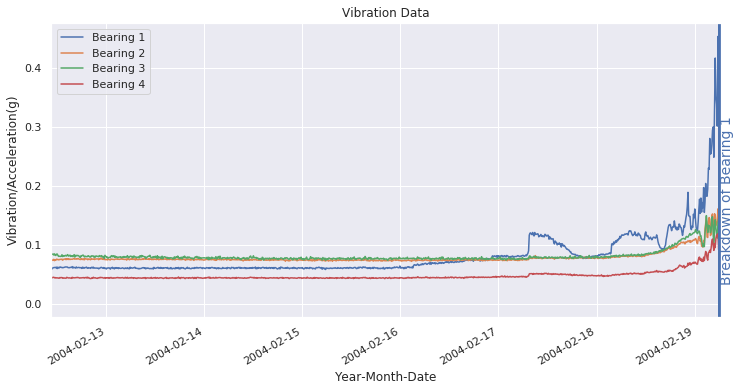

In [0]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

The above figure shows the accelereometer data for all four bearings. Bearing 1 fails at end of measurement, @ 2004-02-19 06:22:39. 

Observing the time plot, it is pretty obvious that the vibration increases after 2004-02-16. However, how does a machine access that there has been an increase in bearing vibration?


## Zooming in Data for Bearing 1

[Text(0, 0.5, 'Vibration/Acceleration(g)'), Text(0.5, 0, 'Month-Date Time')]

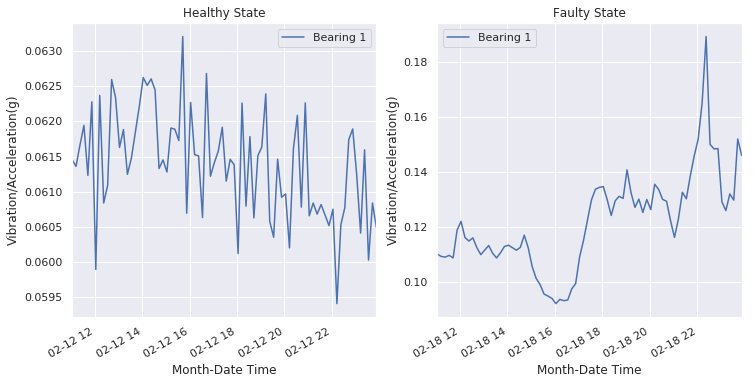

In [0]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

healthy = merged_data['2004-02-12 11:02:39':'2004-02-12 23:52:39']
healthy['Bearing 1'].plot(figsize = (12,6), title="Healthy State" , legend = True, ax=ax1)
ax1.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")

faulty = merged_data['2004-02-18 11:02:39':'2004-02-18 23:52:39']
ax2 = faulty['Bearing 1'].plot(figsize = (12,6), title="Faulty State" , legend = True, ax= ax2)
ax2.set(xlabel="Month-Date Time", ylabel="Vibration/Acceleration(g)")



The above graphs shows the vibration data fro bearing 1 at the for the same time peiod , '11:02:39' to "23:52:39' on 12th (Healthy) and on the 18th(Faulty/Poor Heath Score).

The vibration is definetly higher. Furthermore, the frequency component are also different.  It is easy to identify for one variable (one dimension). However, when the number of variables (dimensions) increase, i.e. when we consider more variable likes temperature, humidity etc., the complexity increases.

The beauty of ML lies in the fact that the same methods hold true for mutli dimensional data as well. Multiple sensor variables (dimensions) can be considered to get a more accurate measure of the "Health Score" of a machine.

# Anamoly Detection using Prophet Package (Black Box Modelling)

Anomaly detection problem for time series can be formulated as finding outlier data points relative to some standard or usual signal. Our focus shall be from a machine persopective, such as unexpected spikes, level shift pointing to deteriorating health of a machine.

Prophet is open source software released by Facebook’s Core Data Science team.


In [0]:
from fbprophet import Prophet

## Creating Training Data Set
The training of the anamoly detection model is using data from the healthy phase of the bearing. The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [0]:
healthy_bearing1 = merged_data['2004-02-12 10:32:39':'2004-02-15 23:42:39']['Bearing 1']

# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy_bearing1.index
prophet_healthy_train['y'] = healthy_bearing1.values

prophet_healthy_train.head()

,ds,y
0,2004-02-12 10:32:39,0.058333
1,2004-02-12 10:42:39,0.058995
2,2004-02-12 10:52:39,0.060236
3,2004-02-12 11:02:39,0.061455
4,2004-02-12 11:12:39,0.061361


## Creating the Model 

Calling the In-Bulit Prophet Module for training a model

In [0]:
m = Prophet(interval_width = 1)
# Using the training data from "healthy part"
m.fit(prophet_healthy_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


## Evaluation on Training Data

Displaying Prophet plot


[Text(45.125, 0.5, 'Vibration/Acceleration(g)'),
 Text(0.5, 30.5, 'Month (MM)-Date(DD) Time')]

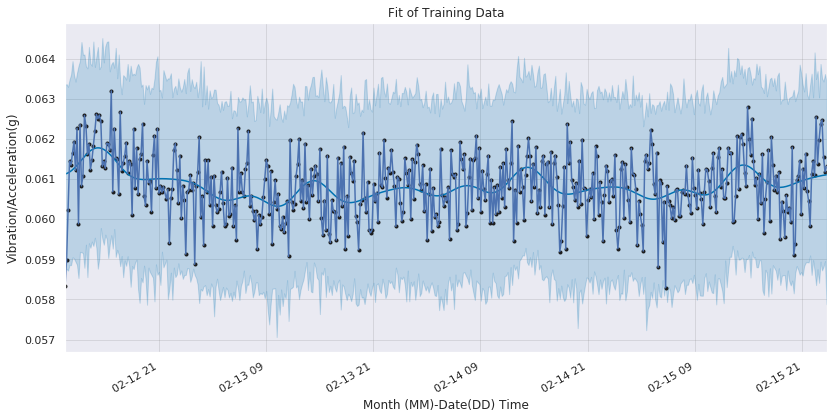

In [0]:
forecast = m.predict(prophet_healthy_train)
forecast['fact'] = prophet_healthy_train['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = healthy_bearing1.plot(figsize = (12,6), title="Fit of Training Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")


The black points are the true data points of the vibration sensor. The blue line represents the fitted line (trend line) with the light blue portion showing the acceptable variance.

## Evaluation on Test Data (Unseen, Fault Data)

Finally, the moment of truth!

Can the model developed above detect faulty machine condition. To evaluate this, the fault portion of the data is fed into the model.

Note that this data has not been trained by the training model. 

Displaying Prophet plot


Text(731624.875, 0.057, 'Actual/Healthy')

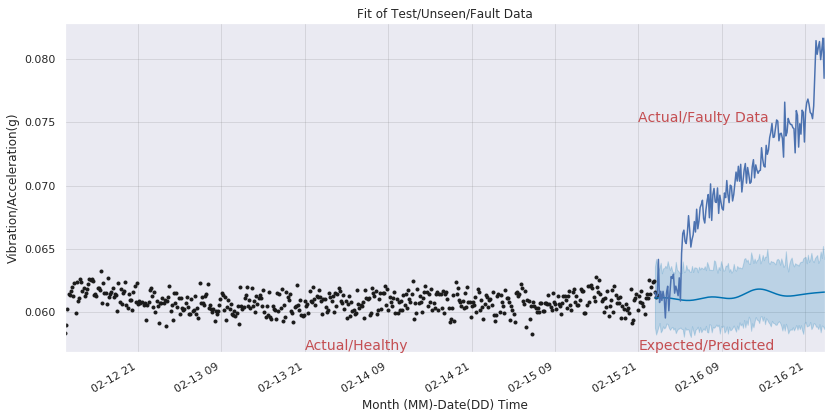

In [0]:
prophet_faultydata = merged_data['2004-02-15 23:22:39':'2004-02-16 23:52:39']['Bearing 1']
prophet_faultydata.head()

prophet_faulty_test = pd.DataFrame()

prophet_faulty_test['ds'] = prophet_faultydata.index
#pd.to_datetime(prophet_healthy.index, format='%Y.%m.%d.%H.%M.%S')
prophet_faulty_test['y'] = prophet_faultydata.values

forecast = m.predict(prophet_faulty_test)
forecast['fact'] = prophet_faulty_test['y'].reset_index(drop = True)
print('Displaying Prophet plot')
fig1 = m.plot(forecast)
fig1 = prophet_faultydata.plot(figsize = (12,6),title="Fit of Test/Unseen/Fault Data")
fig1.set(xlabel="Month (MM)-Date(DD) Time", ylabel="Vibration/Acceleration(g)")
fig1.text(731626.875,0.057,'Expected/Predicted', fontsize=14, color='r')
fig1.text(731626.875,0.075,'Actual/Faulty Data', fontsize=14, color='r')
fig1.text(731624.875,0.057,'Actual/Healthy', fontsize=14, color='r')

The black points are the true data points of the vibration sensor. The blue line represents the expected values from 2004-02-15, 23:42:39  with the light blue portion showing the acceptable variance.

Clearly, the values are higher than the predicted values and an alarm can be sounded.

In [0]:
# Healper functions to annotate the graph.
print(fig1.get_xticks())
print(fig1.get_yticks())

[731623.875 731624.375 731624.875 731625.375 731625.875 731626.375
 731626.875 731627.375 731627.875]
[0.055 0.06  0.065 0.07  0.075 0.08  0.085]


#Conclusion

By analysing past trends of healthy, the model learns the expected trend with acceptable variance (hyperparameter).The trained model predicts the trends for the future and if any deviation is observed, an alarm can be raised.

The same principle hold true for analysing multiple signal (multi-dimensional) at a time and creating a single metric like, the "health score" of a machine.

Using such predictive maintenace strategies, one can find the earliest stages of damage and reduce operating costs. Rather than shutting down equipment for scheduled preventive maintenance routines, maintenance can be planned to match convenient schedules and improve reliability. Predictive maintenance uses sensors, machine learning, and advanced algorithms to detect faults and predict failure. Connecting to the Industrial Internet of Things (IIoT) enables access to historical baseline data while building the statistical and trend analyses that point to why and where problems occur and what actions are needed. 

# References


1.   https://www.plantengineering.com/articles/roller-bearings-and-predictive-analytics/
2.   https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7
3. https://iot.ieee.org/images/files/pdf/phm2017/06-19-2017-Rick-Durham_IEEE-PHM_Presentation20170610.pdf
4. https://facebook.github.io/prophet/docs/quick_start.html


